In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import curve_fit
import datetime

$$H_R = \frac{i\eta\Omega}{2}\left(\sigma_+a+\sigma_-a^\dagger\right)$$
$$H_B = \frac{i\eta\Omega}{2}\left(\sigma_-a+\sigma_+a^\dagger\right)$$

$$\left|0\right>\otimes\left|\overline{n}\right>$$

$$\frac{P_{R, e}(t)}{P_{B, e}(t)-P_{R, e}(t)}$$

$$\overline{n}\approx 5$$

## Read the file

In [2]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion1, ion1_raw, ion1_bottom, ion1_top, ion2, ion2_raw, \
    ion2_bottom, ion2_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, 
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion1

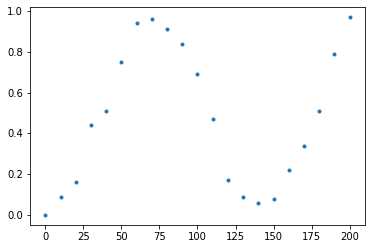

In [3]:
xb, BSB = readFile('ms_blue_time_scan_rfsoc_003')
plt.plot(xb, BSB, '.')

## Define Hamiltonian

In [4]:
times = xb
nMax = 20

In [5]:
def H(n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times):
    H_R = etaOmega/2*(qt.tensor(qt.sigmap(), qt.destroy(nMax))+qt.tensor(qt.sigmam(), qt.create(nMax)))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))
    
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.thermal_dm(nMax, n))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.thermal_dm(nMax, n))

    c_ops = [
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result.expect[0]

(0, 1)

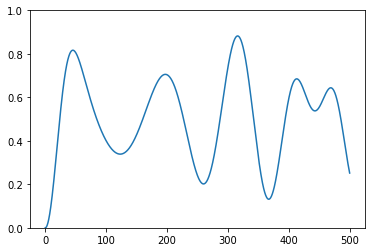

In [6]:
def H2(n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times):
    H_R = etaOmega/2*(qt.tensor(qt.sigmap(), qt.destroy(nMax))+qt.tensor(qt.sigmam(), qt.create(nMax)))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))
    
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.thermal_dm(nMax, n))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.thermal_dm(nMax, n))

    c_ops = [
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result

H0 = []
n0 = 1
etaOmega = 0.05
count = 0
times = np.linspace(0,500,2001)
results = H2(n0, False, 0, etaOmega, times)# Test Blue sideband
    
plt.plot(times,results.expect[0])
plt.ylim([0,1])

### Test the Hamiltonian

(0, 1)

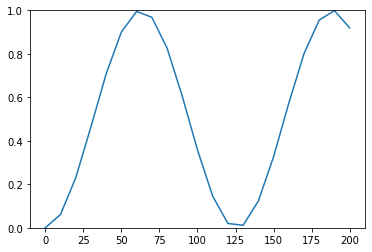

In [7]:
H0 = []
n0 = 0
etaOmega = 0.05
count = 0
for t in xb:
    H0.append(H(n0, False, 0, etaOmega, [0,t])[-1]) # Test Blue sideband
    
plt.plot(xb,H0)
plt.ylim([0,1])

## Curve fit

In [8]:
def Red(x, n0, etaOmega):
    return H(n0, True, 0, etaOmega, x)

def Blue(x, n0, etaOmega):
    return H(n0, False, 0, etaOmega, x)

def FitRed(xdata, ydata, guess):
    popt, pcov = curve_fit(Red, xdata, ydata, guess, sigma=np.sqrt(ydata*(1-ydata)/50)+0.005)
    plt.plot(xdata, Red(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.errorbar(xdata, ydata, yerr=np.sqrt(ydata*(1-ydata)/100)+0.005 ,ls='',marker='o')
    plt.legend()
    print(popt)
    print(np.sqrt(np.diag(pcov)[0]))
    return popt, np.sqrt(np.diag(pcov)[0])
    
def FitBlue(xdata, ydata, guess):
    popt, pcov = curve_fit(Blue, xdata, ydata, guess, sigma=np.sqrt(ydata*(1-ydata)/50)+0.005, absolute_sigma = False)
    plt.plot(xdata, Blue(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.errorbar(xdata, ydata, yerr=np.sqrt(ydata*(1-ydata)/100)+0.005 ,ls='',marker='o')
    plt.legend()
    plt.show()
    print(popt)
    print(np.sqrt(np.diag(pcov)[0]))
    return popt, np.sqrt(np.diag(pcov)[0])

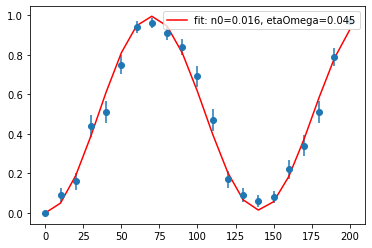

[0.01580425 0.044634  ]
0.016403350864300857


In [9]:
### Test fit: BSB
filename = 'ms_blue_time_scan_rfsoc_003'
xb, BSB = readFile(filename)
xdata = xb
ydata = BSB
guess = np.array([0.4, 0.05])
BSB_fit = FitBlue(xdata, ydata, guess)

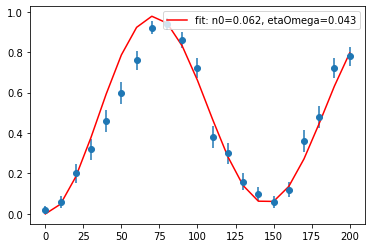

[0.06214648 0.04301004]
0.030094140454489746


NameError: name 'ns' is not defined

In [10]:
filename = 'ms_blue_time_scan_rfsoc_004'
xb, BSB = readFile(filename)
guess = np.array([0.05, 0.044])
BSB_fit, nerr= FitBlue(xb, BSB, guess)
ns.append(BSB_fit[0])
errs.append(nerr)

The loop fitting doesn't work well because it's highly sensitive to the initial guess (expecially the `etaOmega` parameter). If needed we have to change the guess value mannually.

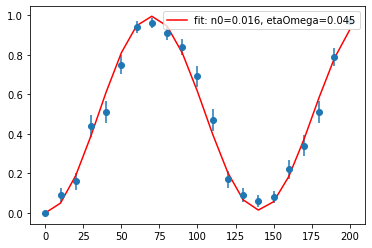

[0.01580458 0.044634  ]
0.016403538387014666


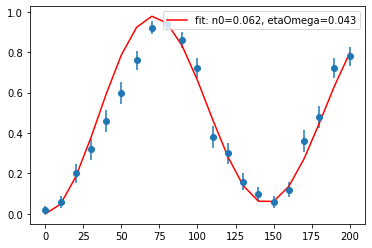

[0.06214635 0.04301002]
0.03008870813867939


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [21]:
ls = [3,4,5,6,7]
ns = []
errs = []
for l in ls:
    filename = 'ms_blue_time_scan_rfsoc_'+str(int(l)).zfill(3)
    xb, BSB = readFile(filename)
    guess = np.array([0.01, 0.046])
    BSB_fit, nerr= FitBlue(xb, BSB, guess)
    ns.append(BSB_fit[0])
    errs.append(nerr)

# Zigzag mode

In [11]:
ls_blue = [3,4,5,6,7,9,10,11]
ls_red = [3,4,5,6,7,9,10,11]
ns = []
err_ns = []
for i in range(len(ls_blue)):
    filename = 'ms_blue_time_scan_rfsoc_'+str(int(ls_blue[i])).zfill(3)
    xb, BSB = readFile(filename)
    sigma_i_sq=BSB*(1-BSB)/50
    sigma_pb = np.sqrt(sum(sigma_i_sq))/len(sigma_i_sq)
    
    filename = 'ms_red_time_scan_rfsoc_'+str(int(ls_red[i])).zfill(3)
    xr, RSB = readFile(filename)
    sigma_i_sq=RSB*(1-RSB)/50
    sigma_pr = np.sqrt(sum(sigma_i_sq))/len(sigma_i_sq)
    
    pop_blue = sum(BSB)/len(BSB)
    pop_red = sum(RSB)/len(RSB)
    nbar = pop_red/(pop_blue-pop_red)
    ns.append(nbar)
    
#     sigma_pbpr = sum((BSB-pop_blue)*(RSB-pop_red))/len(BSB)
    sigma_pbpr = 0
    sigma_n = nbar/(pop_blue-pop_red)* \
            np.sqrt(pop_blue**2/pop_red**2*sigma_pr**2+sigma_pb**2+2*pop_blue/pop_red*sigma_pbpr)
    err_ns.append(sigma_n)
wait_time = np.array([0, 0.01, 0.05, 0.1, 0.20, 0.15, 0.075, 0.125]) # Unit: s

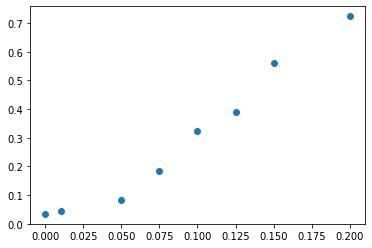

In [12]:
plt.plot(wait_time, ns, 'o')

In [13]:
ns

[0.03416149068322983,
 0.044843049327354265,
 0.08188585607940446,
 0.3220973782771536,
 0.724137931034483,
 0.5595854922279794,
 0.1847133757961784,
 0.38867924528301906]

## Define heating rate fit

In [131]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [132]:
def Heating(x, a, b):
    return a * x + b
def heatingFit(xdata, ydata, yerr):
#     popt, pcov = curve_fit(Heating, xdata, ydata, sigma=yerr, absolute_sigma= False)
    popt, pcov = curve_fit(Heating, xdata, ydata, absolute_sigma= False)
    print(r'Heating rate = '+str(popt[0])+r'$\pm$'+str(np.sqrt(np.diag(pcov)[0]))+r' quanta/s ')
    print('Intersept = '+str(popt[1])+r'$\pm$'+str(np.sqrt(np.diag(pcov)[1]))+' quanta')
    fitY = [Heating(x, popt[0], popt[1]) for x in xdata]
    'fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt)
    plt.figure(figsize=(10,6))
    plt.plot(xdata, Heating(xdata,*popt), 'grey')
    plt.errorbar(xdata, ydata, yerr,ls='',marker='o',mec='firebrick',ecolor='firebrick',mfc='pink')
#     plt.text(0,2.8, r'Heating rate = '+str(round(popt[0],3))+r' $\pm$ '+str(round(np.sqrt(np.diag(pcov)[0]),3))+r' q/s')
    plt.xlabel('Time (s)')
    plt.ylabel('Motional quanta')
    plt.title('Heating rate = %5.2f' % popt[0]+r' quanta/s ')
    plt.show()

Heating rate = 3.607710991243524$\pm$0.2992686421148156 quanta/s 
Intersept = -0.02767137184913323$\pm$0.03284294279839822 quanta


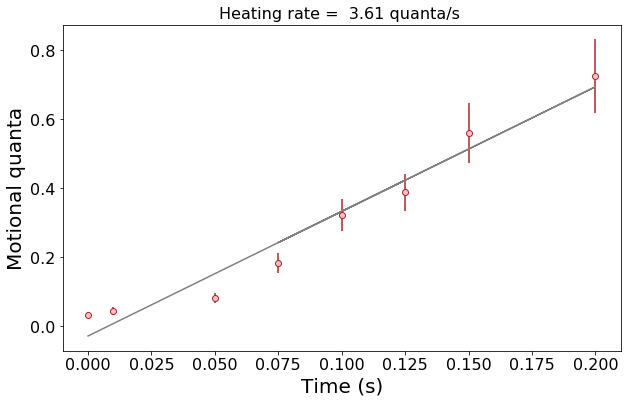

In [133]:
pp = heatingFit(wait_time, ns, err_ns)

# COM mode

In [134]:
ls_blue = [15,16,17,18,19,20,21,22]
ls_red = [15,16,17,18,19,20,21,22]
ns = []
err_ns = []
for i in range(len(ls_blue)):
    filename = 'ms_blue_time_scan_rfsoc_'+str(int(ls_blue[i])).zfill(3)
    xb, BSB = readFile(filename)
    sigma_i_sq=BSB*(1-BSB)/50
    sigma_pb = np.sqrt(sum(sigma_i_sq))/len(sigma_i_sq)
    
    filename = 'ms_red_time_scan_rfsoc_'+str(int(ls_red[i])).zfill(3)
    xr, RSB = readFile(filename)
    sigma_i_sq=RSB*(1-RSB)/50
    sigma_pr = np.sqrt(sum(sigma_i_sq))/len(sigma_i_sq)
    
    pop_blue = sum(BSB)/len(BSB)
    pop_red = sum(RSB)/len(RSB)
    nbar = pop_red/(pop_blue-pop_red)
    ns.append(nbar)
    
#     sigma_pbpr = sum((BSB-pop_blue)*(RSB-pop_red))/len(BSB)
    sigma_pbpr = 0
    sigma_n = nbar/(pop_blue-pop_red)* \
            np.sqrt(pop_blue**2/pop_red**2*sigma_pr**2+sigma_pb**2+2*pop_blue/pop_red*sigma_pbpr)
    err_ns.append(sigma_n)
wait_time = np.array([0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006,0.0005]) # Unit: s

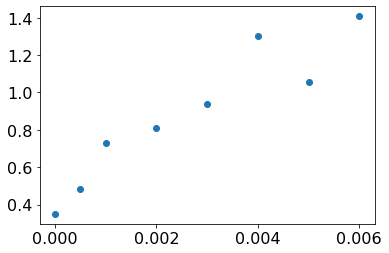

In [135]:
plt.plot(wait_time, ns, 'o')

Heating rate = 159.3403047617121$\pm$23.392112890161222 quanta/s 
Intersept = 0.45654212067429595$\pm$0.0790025102729258 quanta


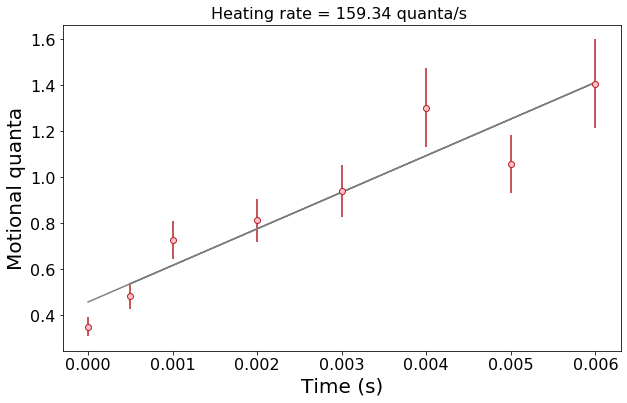

In [136]:
pp = heatingFit(wait_time, ns, err_ns)

In [127]:
ns

[0.3497267759562842,
 0.7266435986159173,
 0.8118466898954698,
 0.9386973180076627,
 1.3031674208144792,
 1.0579150579150578,
 1.407582938388625,
 0.48257372654155506]